In [1]:
import warnings

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import QTable
from astropy.time import Time

from astroquery.vizier import Vizier

In [2]:
ngc188_table = QTable.read("gaia_results.fits")
ngc188_table = ngc188_table[ngc188_table["parallax"] > 0.25 * u.mas]

ngc188_center_3d = SkyCoord(
    12.11 * u.deg,
    85.26 * u.deg,
    distance=1.96 * u.kpc,
    pm_ra_cosdec=-2.3087 * u.mas / u.yr,
    pm_dec=-0.9565 * u.mas / u.yr,
)

# Deal with masked quantity data in a backwards-compatible way:
parallax = ngc188_table["parallax"]
if hasattr(parallax, "mask"):
    parallax = parallax.filled(np.nan)

velocity_data = {
    "pm_ra_cosdec": ngc188_table["pmra"],
    "pm_dec": ngc188_table["pmdec"],
    "radial_velocity": ngc188_table["radial_velocity"],
}
for k, v in velocity_data.items():
    if hasattr(v, "mask"):
        velocity_data[k] = v.filled(0.0)
    velocity_data[k][np.isnan(velocity_data[k])] = 0.0

ngc188_coords_3d = SkyCoord(
    ra=ngc188_table["ra"],
    dec=ngc188_table["dec"],
    distance=Distance(parallax=parallax),
    obstime=Time("J2015.5"),
    **velocity_data,
)

sep3d = ngc188_coords_3d.separation_3d(ngc188_center_3d)
pm_diff = np.sqrt(
    (ngc188_table["pmra"] - ngc188_center_3d.pm_ra_cosdec) ** 2
    + (ngc188_table["pmdec"] - ngc188_center_3d.pm_dec) ** 2
)

ngc188_members_mask = (sep3d < 50 * u.pc) & (pm_diff < 1.5 * u.mas / u.yr)
ngc188_members = ngc188_table[ngc188_members_mask]
ngc188_members_coords = ngc188_coords_3d[ngc188_members_mask]
len(ngc188_members)

265

In [3]:
# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/246", columns=["*", "Date"])
v.ROW_LIMIT = -1

result = v.query_region(ngc188_center_3d, radius=0.5 * u.deg)
tmass_table = result[0]

In [4]:
tmass_table[:3]

RAJ2000,DEJ2000,2MASS,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,Qflg,Rflg,Bflg,Cflg,Xflg,Aflg,Date
deg,deg,,mag,mag,mag,mag,mag,mag,,,,,,,
float64,float64,str17,float32,float32,float32,float32,float32,float32,str3,str3,str3,str3,uint8,uint8,str10
12.773169,84.780273,00510556+8446489,15.150,0.052,14.507,0.055,14.323,0.066,AAA,222,111,000,0,0,1999-10-19
13.399166,84.774055,00533579+8446265,16.476,0.116,16.172,0.221,15.392,0.177,BDC,222,111,000,0,0,1999-10-19
13.986755,84.804283,00555682+8448154,16.717,0.144,15.743,0.157,15.722,0.226,BCD,222,111,000,0,0,1999-10-19


In [5]:
tmass_coords = SkyCoord(tmass_table["RAJ2000"], tmass_table["DEJ2000"])
len(tmass_coords)

5014

In [6]:
np.unique(tmass_table["Date"])

masked_array(data=['1999-10-19'],
             mask=False,
       fill_value='N/A',
            dtype='<U10')

In [7]:
tmass_epoch = Time(np.unique(tmass_table["Date"]))

In [8]:
ngc188_members_coords_1999 = ngc188_members_coords.apply_space_motion(tmass_epoch)

In [9]:
idx_gaia, sep2d_gaia, _ = ngc188_members_coords_1999.match_to_catalog_sky(tmass_coords)

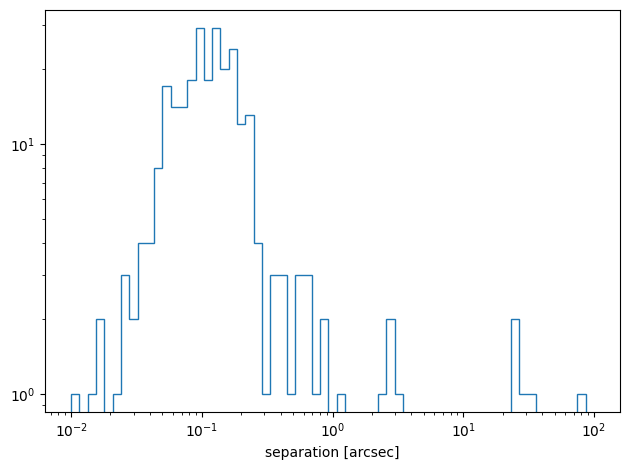

In [10]:
plt.hist(sep2d_gaia.arcsec, histtype="step", bins=np.logspace(-2, 2.0, 64))
plt.xlabel("separation [arcsec]")
plt.xscale("log")
plt.yscale("log")
plt.tight_layout()

In [11]:
(sep2d_gaia < 2 * u.arcsec).sum(), len(ngc188_members)

(np.int64(256), 265)

In [12]:
Jmag = tmass_table["Jmag"][idx_gaia]  # note that we use the index array returned above
Gmag = ngc188_members["phot_g_mean_mag"]
Bmag = ngc188_members["phot_bp_mean_mag"]

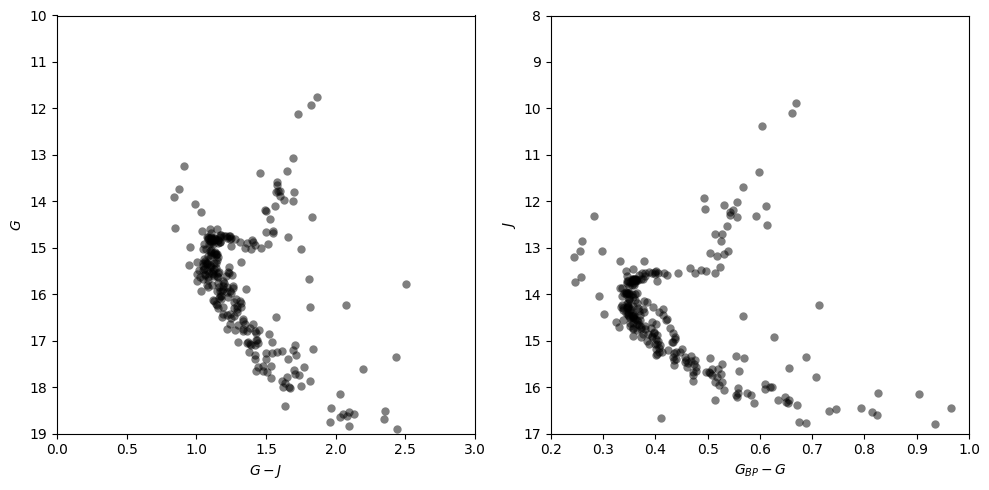

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(Gmag - Jmag, Gmag, marker="o", color="k", linewidth=0, alpha=0.5)
ax.set_xlabel("$G - J$")
ax.set_ylabel("$G$")
ax.set_xlim(0, 3)
ax.set_ylim(19, 10)  # backwards because magnitudes!

ax = axes[1]
ax.scatter(Bmag - Gmag, Jmag, marker="o", color="k", linewidth=0, alpha=0.5)
ax.set_xlabel("$G_{BP} - G$")
ax.set_ylabel("$J$")
ax.set_xlim(0.2, 1)
ax.set_ylim(17, 8)  # backwards because magnitudes!

fig.tight_layout()